# Team 110

Project: Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost

* James Yoo : jamesy5@illinois.edu
* Scott Girten : sgirten2@illinois.edu
* Edwin Jamsranjav : edwinj2@illinois.edu

[Video Link](https://youtu.be/nzqyC85mAbw)

# Introduction

Sepsis is a common disease which has become a global public health issue due to a relatively high prevalence and mortality rate.  Sepsis has an overall mortality rate of approximately 30% and is the cause of over 5.3 million annual deaths globally.  Sepsis is usually induced by an infection that has entered the bloodstream and can become an acute condition which results in life-threatening organ dysfunction.  Early identification and treatment of sepsis is essential for reducing the need for acute critical care and reducing the mortality rate of sepsis.  Improvements for treating sepsis could help to reduce the number of deaths related to sepsis as well as reduce the cost burden of treating sepsis on public finances.

Currently diagnosing sepsis relies on using serum markers or other laboratory tests to confirm sepsis.  However, by the time test for the biomarkers would be positive for sepsis the condition will have advanced to a more serious state and as a result it will be more difficult to successfully treat sepsis.  If a predictive model could be reasonably accurate in predicting if a patient is at risk of sepsis based on historical data rather than laboratory samples, that could have the potential to lead to earlier interventions based on the information in a patient's medical record.  If a predictive model could aid early intervention as oppossed to waiting for laboratory tests to confirm sepsis, that could potentially reduce the need for acute care and reduce the mortality rate associated with sepsis.

Best practices for diagnosing sepsis mostly rely on scoring systems that incorporate a relatively limited number of variables to produce a score that indicates the risk a patient has of developing sepsis. The scoring systems face challenges in predicting sepsis due to the fact that the scoring systems rely on a relatively limited number of predictor variables and also generally assume that the predictor variables are linearly related to the prediction of developing sepsis.  Additionally these scoring systems are relatively tedious to utilize since it usually requires clinicians to manually enter values into an application to calculate the score for a patient.  These shortcomings in addition to poor predictive strength, wide variances in predictive ranges and general operational difficulties have created an opportunity to apply predictive modeling to deliver improved predictive abilities and reduce the operational burden of utilizing the model.

Our paper proposed utilizing XGBoost for predicting the 30-day mortality of patients diagnosed with sepsis-3 based on the results of comparing SAPs-II scoring model, logistic regression and XGBoost.  Utilizing XGBoost would allow for clinicians to incorporate a wider range of data points about a patients' medical history for predicting 30-day mortality due to sepsis.  The XGBoost model was able to achieve the highest ROC-AUC of 0.857 for predicting 30-day mortality.  The figure below shows the ROC-AUC results for each of the 3 models from the original paper.

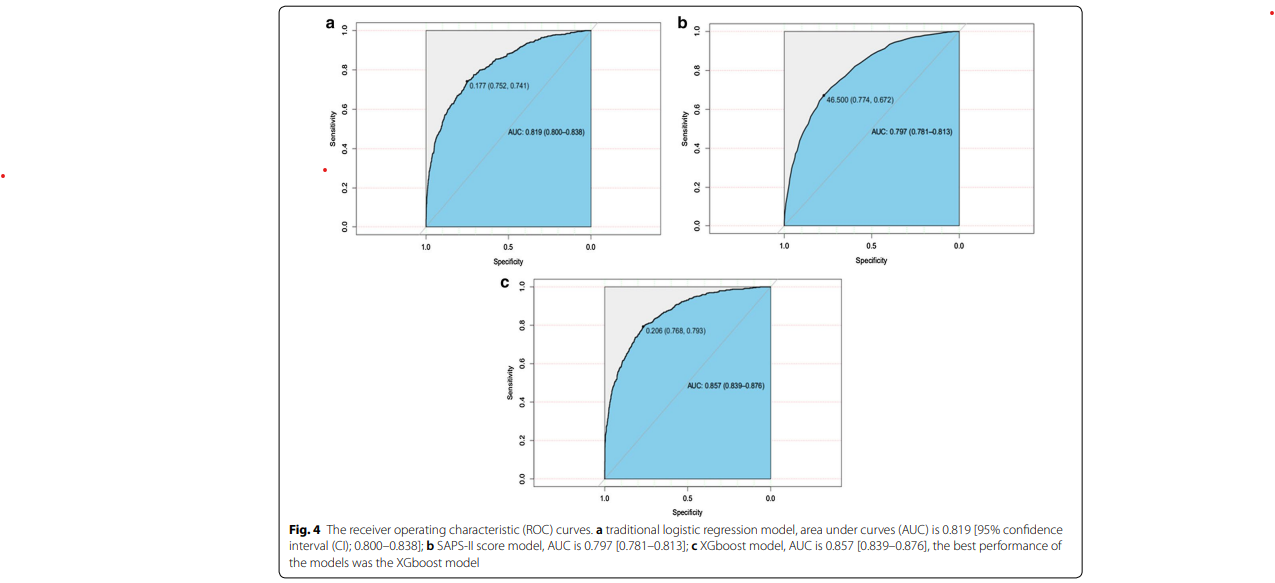



# Scope of Reproducibility:

**Hypothesis 1: The XGBoost model will exhibit superior predictive performance, as measured by AUC-ROC and DCA, compared to logistic regression, SAPS-II Score prediction model, and Multi-layer Perceptron, for 30-day mortality prediction in patients with sepsis-3.**

**Experiment 1: Train logistic regression, SAPS-II Score prediction model, XGBoost, and Multi-layer Perceptron on the MIMIC-III dataset for 30-day mortality prediction in patients with sepsis-3. Evaluate the models' performance using AUC-ROC and DCA.**

**Hypothesis 2: The XGBoost model will demonstrate enhanced clinical utility, reflected in its ability to provide actionable insights for precise management and therapy decisions for patients with sepsis-3, compared to logistic regression, SAPS-II Score prediction model, and Multi-layer Perceptron.**

**Experiment 2: Use Boruta Algorithm to identify a different feature set and assess the clinical utility of the XGBoost model, logistic regression, SAPS-II Score prediction model, and Multi-layer Perceptron by evaluating their predictions in the context of clinical decision-making. Analyze the models' predictions to determine their impact on therapy decisions using clinical guidelines or expert opinions.**

# Methodology

## Environment

Python Version is 3.10.12

Package Information
* Loading Data
  * google.colab
* Data preprocessing and splits
  * sklearn.impute
  * sklearn.model_selection
* Plotting
  * scikit-plot
  * matplotlib.pyplot
* Model Building
  * torch
  * torch.nn
  * numpy
  * pandas
  * sklearn.linear_model
  * torch.utils.data
  * xgboost
* Results
  * sklearn.metrics  
* Basic Exploration
  * RFE

In [ ]:
!python --version

# required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from google.colab import drive
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier

Python 3.10.12


In [ ]:
# Plotting
!pip install scikit-plot

In [ ]:
import scikitplot as skplt

##  Data

### Data Download

  * Source of the data: The authors' data was collected from the MIMIC III V1.4 Database from [https://physionet.org/content/mimiciii/1.4/](https://physionet.org/content/mimiciii/1.4/). They publically provided their raw dataset that they used for the models on their paper under the supplementary information: [Link](https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-020-02620-5#Sec14). We suggest downloading this file and uploading it into google drive and modify the variable file paths. ALternatively, you can download the data from out github repo below
  * The boruta_data_path is to generate a feature list using the boruta algorithm selected features mentioned later in the notebook. We included this dataset to our github repo: https://github.com/jamyooes/dlh_project/tree/main
  * If ran locally - there is no need for the mounting and can specify the paths for the boruta data path and raw dataset after downloading the files

In [ ]:
# Mount google drive
drive.mount('/content/drive')
boruta_data_path = '/content/drive/MyDrive/raw_data_dlh/Boruta Output.csv'
data_path = '/content/drive/MyDrive/raw_data_dlh/12967_2020_2620_MOESM1_ESM.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Process Raw Data

Data cleaning has been simplified as the authors have provided their raw dataset on their paper.

The required preprocessing steps is spliting the dataset into train-test splits and imputation for logistic regression (as it will throw errors)

   Below are the helper functions
   * load_raw_data : loads the raw data
   * calculate_stats : prints out basic statistics related to the data
   * process_data : Performs the 80-20 train-test split on the dataset for each model's features

In [ ]:
# dir and function to load raw data
def load_raw_data(raw_data_dir):
  """
  Data has been preprocess by the authors of the paper
  Load the data as a dataframe
  """
  data_df = pd.read_csv(data_path)
  return data_df

def calculate_stats(raw_data):
  """
  Calculate the Statistics of the dataset

  This function takes in the raw_data and displays the basic statistics like
  the size of the dataset and the label distribution

  TODO - MORE STATS
  """
  survivors = len(raw_data[raw_data["thirtyday_expire_flag"] == 0])
  deceased = len(raw_data[raw_data["thirtyday_expire_flag"] == 1])
  print(f"There are {len(raw_data)} patient data used for training")
  print(f"The shape of the dataset is {raw_data.shape}")
  print(f"The distribution of the data is {survivors} survivors and {deceased} deceased patients")
  print(f"{survivors/len(raw_data) * 100}% are survivors and {deceased/len(raw_data) * 100}% are deceased")
  return None


def process_data(raw_data, lr_feats, xgb_feats):
  """

  Class labels is the thirtyday_expire_flag, which denotes whether the patient has passed away or lived.

  There is imputation on the data for logstic regression as errors get thrown otherwise

  Input data is the raw data, the logistic regression features, and the xgboost features

  Output will be the train and test splits for the models - LR, XGBoost, SAPS model, and the MLP Model.

  This function will split the dataset into train and test splits
  """

  """
  Logistic Regression
  """
  # Feature and target
  logistic_feats = raw_data[lr_feats[:-1]]
  logistic_target = raw_data[lr_feats[-1]]

  # Train and Test splits
  X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(logistic_feats, logistic_target,
                                                                  test_size = 0.2, stratify = logistic_target, random_state = 42)
  # Impute the missing features for the logistic regression
  lr_imputer = SimpleImputer(strategy = 'mean')
  X_train_lr = lr_imputer.fit_transform(X_train_lr)
  X_test_lr = lr_imputer.transform(X_test_lr)

  """
  XGBOOST
  """
  xgboost_feats = raw_data[xgb_feats[:-1]]
  xgboost_target = raw_data[xgb_feats[-1]]
  X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(xgboost_feats, xgboost_target,
                                                                  test_size = 0.2, random_state = 42)

  """
  MLP
  """
  # Create tensors
  X_train_mlp = torch.from_numpy(X_train_lr).type(torch.float)
  y_train_mlp = torch.from_numpy(y_train_lr.to_numpy()).type(torch.float)

  X_test_mlp = torch.from_numpy(X_test_lr).type(torch.float)
  y_test_mlp = torch.from_numpy(y_test_lr.to_numpy()).type(torch.float)

  # create datasets
  train_mlp = TensorDataset(X_train_mlp, y_train_mlp)
  test_mlp = TensorDataset(X_test_mlp, y_test_mlp)

  # create data loaders
  batch_size = 32
  train_mlp_loader = DataLoader(train_mlp, batch_size=batch_size, shuffle=True)
  test_mlp_loader= DataLoader(test_mlp, batch_size=batch_size)


  return [X_train_lr, X_test_lr, y_train_lr, y_test_lr], [X_train_xg, X_test_xg, y_train_xg, y_test_xg], [train_mlp_loader, test_mlp_loader]



#### Features from original paper

##### Command to load the raw dataset

In [ ]:
raw_data = load_raw_data(data_path)

##### Basic Figures of data

The data contains only the first admission of the spesis patient who are older than 18 years old with all the lab results are used for the analysis.

Some basic figures of the data such as the death rate from diagonosis are shown below

Text(0.5, 1.0, 'Status of patients after Sepsis Diagnosis')

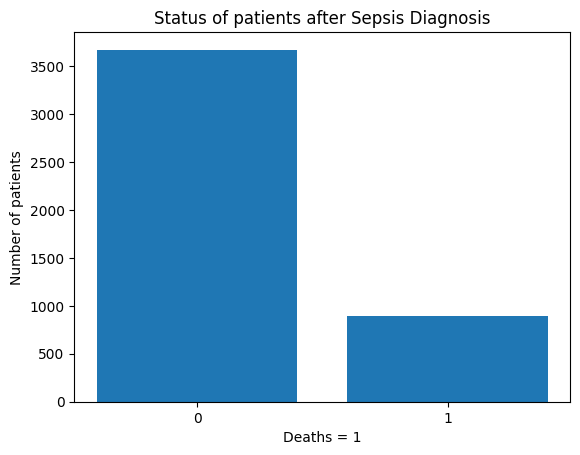

In [ ]:
# 30 day deaths figure
deaths_values = raw_data['thirtyday_expire_flag'].value_counts()
plt.bar(deaths_values.index, deaths_values.values)
plt.xlabel('Deaths = 1')
plt.ylabel('Number of patients')
plt.xticks([0, 1])
plt.title('Status of patients after Sepsis Diagnosis')

Text(0.5, 1.0, 'Patients with diabetes')

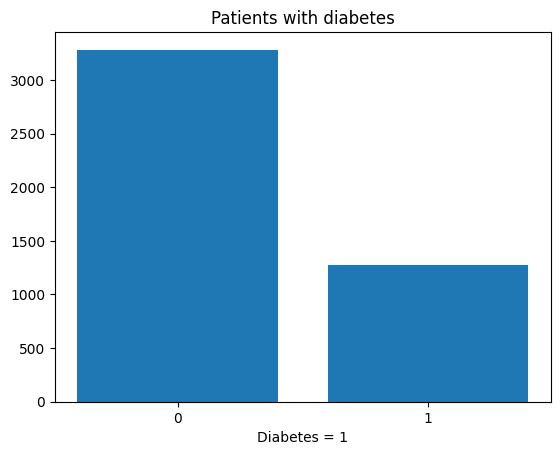

In [ ]:
# diabetes
deaths_values = raw_data['diabetes'].value_counts()
plt.bar(deaths_values.index, deaths_values.values)
plt.xlabel('Diabetes = 1')
plt.ylabel('')
plt.xticks([0, 1])
plt.title('Patients with diabetes')

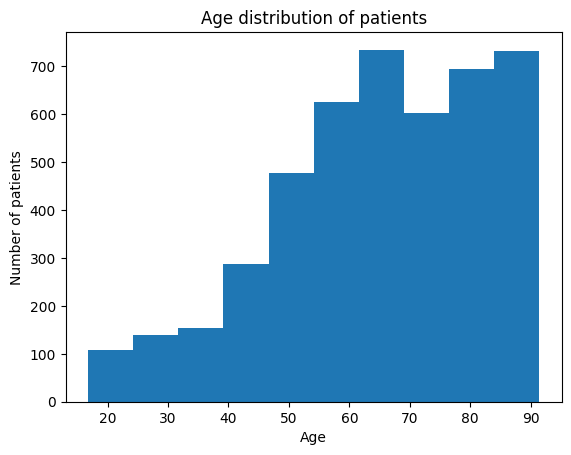

In [ ]:
# age
age_group = raw_data['age']
plt.hist(age_group, bins = 10)
plt.title('Age distribution of patients')
plt.xlabel('Age')
plt.ylabel('Number of patients')
plt.show()

##### Command to preprocess the data

In [ ]:
# These are the features used in the models from the paper
logistic_regression_features = ["sofa", "aniongap_min", "creatinine_min", "chloride_min",
                                "hematocrit_min", "hemoglobin_min", "hemoglobin_max",
                                "lactate_min", "potassium_min", "sodium_max",
                                "bun_min", "bun_max", "wbc_min", "wbc_max", "heartrate_min",
                                "heartrate_mean", "sysbp_min", "meanbp_min", "resprate_mean",
                                "tempc_min", "tempc_max", "spo2_mean", "age", "diabetes",
                                "vent", "thirtyday_expire_flag"]
x_g_boost_features = ["urineoutput", "lactate_min", "bun_mean", "sysbp_min", "metastatic_cancer",
                      "inr_max", "age", "sodium_max", "aniongap_max", "creatinine_min", "spo2_mean",
                      "thirtyday_expire_flag"]
lr_data_list, xgb_data_list, mlp_data_list = process_data(raw_data, logistic_regression_features, x_g_boost_features)

##### Basic Statistics of Data

In [ ]:
calculate_stats(raw_data)
print(f"Training data uses {len(lr_data_list[0])} rows of patient data")
print(f"Testing the model uses {len(lr_data_list[1])} rows of patient data")

There are 4559 patient data used for training
The shape of the dataset is (4559, 106)
The distribution of the data is 3670 survivors and 889 deceased patients
80.50010967317394% are survivors and 19.49989032682606% are deceased
Training data uses 3647 rows of patient data
Testing the model uses 912 rows of patient data


#### Features selected from Boruta algorithm
Feature selection is a crucial aspect of building any predictive model.  The original research paper utilized the experience of medical professionals to identify features that would likely be relevant to predicting mortality from sepsis.  We thought a different approach utilizting the feature selection Boruta would provide an interesting comparison to see if a machine learning feature selection algorithm could identify additional (or different) features that might be relevant to the prediction of sepsis mortality.

In [ ]:
"""
Code used for excuting Boruta algorithm.  Leaving code commented out since it requires around 90 minutes to run for
2,500 iterations.  The variables selected by the algorithm were saved in a csv file and then read back in for modeling.

from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

# Read in data
data = pd.read_csv(data_path)

# columns to remove from analysis for Boruta
drop_cols = ['icustay_id', 'hadm_id', 'intime', 'outtime', 'dbsource', 'suspected_infection_time_poe',
               'antibiotic_time_poe', 'blood_culture_time', 'gender', 'hospital_expire_flag',
               'colloid_bolus', 'crystalloid_bolus', 'subject_id', 'hadm_id.1', 'icustay_id.1']

# target column
target_col = ['thirtyday_expire_flag']

# dataframe for use in boruta
df = data.drop(drop_cols, axis=1)

check_nulls = df.isna().sum()

df2 = df.fillna(0)


# Initialize an RF model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# instantiate int, float and bool data types to address issue with Boruta implementation
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# create Boruta feature selector
feat_selector = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
    max_iter=2500  # number of iterations to perform
)

X = df2.drop(target_col, axis=1)
X2 = df2.drop(target_col, axis=1) # keep for column names
Y = np.array(df2[target_col]).ravel()


X = pd.get_dummies(X, dtype=float)
X2 = pd.get_dummies(X2, dtype=float) # keep for column names
X = np.array(X)

# fit Boruta feature selector
feat_selector.fit(X, Y)

X_filtered = feat_selector.transform(X)

X_col_names = X2.columns

# create output dataframe
feature_ranks = list(zip(X_col_names,
                         feat_selector.ranking_,
                         feat_selector.support_))

df_feature_ranks = pd.DataFrame(feature_ranks, columns=['Feature', 'Rank', 'Keep'])

df_feature_ranks.to_csv('Boruta Output.csv', index=False)

"""
# Results from Boruta feature selection
boruta_df = pd.read_csv(boruta_data_path)

# Keep variables that were selected by Boruta algorithm
boruta_df = boruta_df[boruta_df['Keep'] == True]
boruta_variables = boruta_df['Feature'].tolist()

logistic_regression_features_boruta = boruta_variables
x_g_boost_features_boruta = boruta_variables
lr_data_list_boruta, xgb_data_list_boruta, mlp_data_list_boruta = process_data(raw_data, logistic_regression_features_boruta, x_g_boost_features_boruta)

#calculate_stats(raw_data)

###

##   Models

Paper: Hou, N., Li, M., He, L. et al. Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost., Journal of Translational Medicine, 2020, 18:462, doi: https://doi.org/10.1186/s12967-020-02620-5

The paper does not include any code repository

The paper does not use epochs or layers as the models are Logistic Regression, XGBoost, and SAPS-II Model

For our ablation study, we created two MLP models. The first MLP model uses the features selected in the research paper, while the second MLP model uses the features selected from the Boruta Algorithm. More details are noted under each section of the model.



### Simplified Acute Physiology Score (SAPS-II)
Heuristic scoring system commonly used in assesing ICU patients and the likelihood of mortality within 30 days.

In [ ]:
# SAPS-II Scoring System for calculting 30-day mortality for ICU patients

def saps_II(df):
    '''
    Based on criteria of SAPS-II methodology assign risk value for each criteria
    Use summed risk score to calculate percentage risk of 30-day mortality
    https://www.mdcalc.com/calc/4044/simplified-acute-physiology-score-saps-ii#next-steps
    '''
    # Age criteria
    age_criteria = [
        (df['age'].lt(40)),
        (df['age'].ge(40) & df['age'].lt(60)),
        (df['age'].ge(60) & df['age'].lt(69)),
        (df['age'].ge(70) & df['age'].lt(75)),
        (df['age'].ge(75) & df['age'].lt(80)),
        (df['age'].ge(80))
        ]

    age_value = [0, 7, 12, 15, 16, 18]

    df['saps_age'] = np.select(age_criteria, age_value)
    #check_age = df[['age', 'saps_age']]


    # Heart Rate Criteria
    hr_criteria = [
        (df['heartrate_min'].lt(40)),
        (df['heartrate_min'].ge(40)  & df['heartrate_min'].lt(70)),
        (df['heartrate_min'].ge(70)  & df['heartrate_min'].lt(120)),
        (df['heartrate_min'].ge(120) & df['heartrate_min'].lt(160)),
        (df['heartrate_min'].ge(160))
        ]

    hr_value = [11, 2, 0, 4, 7]

    df['saps_heartrate'] = np.select(hr_criteria, hr_value)
    #check_hr = df[['heartrate_min', 'saps_heartrate']]


    # Systolic BP
    sysbp_criteria = [
        (df['sysbp_min'].lt(70)),
        (df['sysbp_min'].ge(70) & df['sysbp_min'].lt(100)),
        (df['sysbp_min'].ge(100) & df['sysbp_min'].lt(200)),
        (df['sysbp_min'].ge(200))
        ]

    sysbp_value = [13, 5, 0, 2]

    df['saps_sysbp'] = np.select(sysbp_criteria, sysbp_value)
    #check_sysbp = df[['sysbp_min', 'saps_sysbp']]


    # Temperature
    temp_criteria = [
        (df['tempc_min'].ge(39))
        ]

    temp_value = [3]

    df['saps_temp'] = np.select(temp_criteria, temp_value)
    #check_temp = df[['tempc_min', 'saps_temp']]


    # GCS - Glasgow Coma Score, could not find score in data file
    # PaO2/FiO2 - cannot find data in file


    # BUN
    bun_criteria = [
        (df['bun_max'].lt(28)),
        (df['bun_max'].ge(28) & df['bun_max'].le(83)),
        (df['bun_max'].ge(84))
        ]

    bun_value = [0, 6, 10]

    df['saps_bun'] = np.select(bun_criteria, bun_value)
    #check_bun = df[['bun_max', 'saps_bun']]


    # Urine
    urine_criteria = [
        (df['urineoutput'].lt(500)),
        (df['urineoutput']. ge(500) & df['urineoutput'].lt(1000)),
        (df['urineoutput'].ge(1000))
        ]

    urine_value = [11, 4, 0]

    df['saps_urine'] = np.select(urine_criteria, urine_value)
    #check_urine = df[['urineoutput', 'saps_urine']]


    # Sodium
    sodium_criteria = [
        (df['sodium_min'].lt(125)),
        (df['sodium_min'].ge(125) & df['sodium_min'].lt(145)),
        (df['sodium_min'].ge(145))
        ]

    sodium_value = [5, 0, 1]

    df['saps_sodium'] = np.select(sodium_criteria, sodium_value)
    #check_sodium = df[['sodium_min', 'saps_sodium']]


    # Potassium
    potassium_criteria = [
        (df['potassium_min'].lt(3)),
        (df['potassium_max'].ge(5))
        ]

    potassium_value = [3, 3]

    df['saps_potassium'] = np.select(potassium_criteria, potassium_value)
    #check_potassium = df[['potassium_min', 'potassium_max', 'saps_potassium']]


    # Bicarbonate
    bicarb_criteria = [
        (df['bicarbonate_min'].lt(15)),
        (df['bicarbonate_min'].ge(15) & df['bicarbonate_min'].lt(20)),
        (df['bicarbonate_min'].ge(20))
        ]

    bicarb_value = [6, 3, 0]

    df['saps_bicarb'] = np.select(bicarb_criteria, bicarb_value)
    #check_bicarb = df[['bicarbonate_min', 'saps_bicarb']]


    # Bilirubin - did not see column in data file


    # WBC
    wbc_criteria = [
        (df['wbc_min'].lt(1)),
        (df['wbc_max'].ge(20))
        ]

    wbc_value = [12, 3]

    df['saps_wbc'] = np.select(wbc_criteria, wbc_value)
    #check_wbc = df[['wbc_min', 'wbc_max', 'saps_wbc']]


    # Chronic Disease
    chronic_criteria = [
        (df['metastatic_cancer'] == 1)
        ]

    chronic_value = [9]

    df['saps_chronic'] = np.select(chronic_criteria, chronic_value)
    #check_chronic = df[['metastatic_cancer', 'saps_chronic']]

    admission_criteria = [
        (df['first_service'] == 'SURG'),
        (df['first_service'] != 'SURG')
    ]
    admission_value = [8, 6]
    df['saps_admission'] = np.select(admission_criteria, admission_value)



    # List of columns created for calculating the score
    saps_columns = ['saps_age', 'saps_heartrate', 'saps_sysbp', 'saps_temp', 'saps_bun', 'saps_urine',
                    'saps_sodium', 'saps_potassium', 'saps_bicarb', 'saps_wbc', 'saps_chronic', 'saps_admission']

    # Calculate SAPS-II Score
    # Source for calculating mortality probability
    # https://ebmcalc.com/SAPS2.htm
    df['saps_II_score'] = df[saps_columns].sum(axis=1)
    df['logit'] = (0.0737 * df['saps_II_score']) + (0.9971 * np.log(df['saps_II_score']  + 1)) - 7.7631
    df['saps_II_mortality_probability'] = (np.exp(df['logit'])) / (1 + np.exp(df['logit']))
    df['saps_II_prediction'] = (df['saps_II_mortality_probability'] >= 0.5) * 1

    #df_out = df[['thirtyday_expire_flag', 'saps_II_score', 'logit', 'saps_II_mortality_probability', 'saps_II_prediction']] #, 'saps_II_mortality_probability'
    return df['saps_II_prediction'], df['saps_II_mortality_probability'], df['thirtyday_expire_flag']


# Calculate SAPS-II score for each patient
sapsII_pred, sapsII_prob, sapsII_label = saps_II(raw_data)
#sapsII_prob.head(20)


### Logistic Regression
Basic Logistic Regression model for binary classification.Orignal paper did not specify Hyperparameter tuning and our results with the base model is the same as the author's results

In [ ]:
# Logistic Regression Model and Training
# This model is relatively simple and is the point of comparison to the other models according to the paper

# Training Logistic Regression
# Features used in research paper
lr_model = LogisticRegression(random_state = 42)
lr_model.fit(lr_data_list[0], lr_data_list[2])

# Features selected from Boruta
lr_model_boruta = LogisticRegression(random_state = 42)
lr_model_boruta.fit(lr_data_list_boruta[0], lr_data_list_boruta[2])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression(random_state=42)

### XGBoost
No information regarding parameters for XGBoost was mentioned in the original paper, therefore we tuned XGBoost using grid search.  


In [ ]:
xgb_model = XGBClassifier(n_estimators = 50, max_depth = 3, learning_rate = 0.1, objective = 'binary:logistic')
xgb_model_boruta = XGBClassifier(n_estimators = 50, max_depth = 3, learning_rate = 0.1, objective = 'binary:logistic')
"""param_grid = {
    'learning_rate' : [0.01, 0.1, 0.2, 0.5, 1],
    'max_depth' : [2, 3, 4, 5, 10],
    'n_estimators' : [2, 10, 25, 50, 75, 100]
}
xgb_model = GridSearchCV(estimator = xgb_model_init, param_grid = param_grid, cv = 3)"""
print("XGB Training Loss: ")
xgb_model.fit(xgb_data_list[0], xgb_data_list[2], eval_set = [(xgb_data_list[0], xgb_data_list[2]), (xgb_data_list[1], xgb_data_list[3])])
print("Boruta XGB Training Loss: ")
xgb_model_boruta.fit(xgb_data_list_boruta[0], xgb_data_list_boruta[2], eval_set = [(xgb_data_list_boruta[0], xgb_data_list_boruta[2]), (xgb_data_list_boruta[1], xgb_data_list_boruta[3])])

XGB Training Loss: 
[0]	validation_0-logloss:0.48344	validation_1-logloss:0.47384
[1]	validation_0-logloss:0.47123	validation_1-logloss:0.46335
[2]	validation_0-logloss:0.46041	validation_1-logloss:0.45464
[3]	validation_0-logloss:0.45162	validation_1-logloss:0.44717
[4]	validation_0-logloss:0.44328	validation_1-logloss:0.43839
[5]	validation_0-logloss:0.43671	validation_1-logloss:0.43289
[6]	validation_0-logloss:0.43017	validation_1-logloss:0.42653
[7]	validation_0-logloss:0.42388	validation_1-logloss:0.42242
[8]	validation_0-logloss:0.41824	validation_1-logloss:0.41689
[9]	validation_0-logloss:0.41334	validation_1-logloss:0.41302
[10]	validation_0-logloss:0.40915	validation_1-logloss:0.40836
[11]	validation_0-logloss:0.40508	validation_1-logloss:0.40542
[12]	validation_0-logloss:0.40154	validation_1-logloss:0.40135
[13]	validation_0-logloss:0.39811	validation_1-logloss:0.39822
[14]	validation_0-logloss:0.39442	validation_1-logloss:0.39383
[15]	validation_0-logloss:0.39108	validation_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### Multi-Layer Perceptron
MLP classes, one class each for modeling the original feature set and the feature set selected from Boruta.  

For one of our ablation studies, we built a MLP model. The model has three linear layers.
* The first fully connected layer has an input size of 25 and output size of 10.
* The activation function between first and second layer is ReLU
* The second fully connected layer has an input size of 10 and an output size of 5.
* The activation function in between second and third layer is ReLU
* The third fully connected layer has an input size of 5 and an output size of 1.
* The last activation function is a Sigmoid function

The second model using Boruta selected features has 4 linear layers.
* The first layer layer has an input size of 57 and output size of 40.
* The activation function between the first and second layer is ReLU
* The second layer has an input size of 40 and output size of 20.
* The activation function in between the second and third layer is ReLU
* The third layer has an input size of 20 and output size of 5.
* The activation function in between the third and fourth layer is ReLU
* The fourth layer has an input size of 5 and output size of 1.
* The last activation function is a Sigmoid Function

In [ ]:
# simple MLP for features used in research paper
class my_model(nn.Module):
  # use this class to define your model
  def __init__(self):
    super(my_model, self).__init__()

    self.fc1 = nn.Linear(25, 10)
    self.fc2 = nn.Linear(10, 5)
    self.fc3 = nn.Linear(5,1)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))

    return x


# simple MLP for features selected from Boruta
class my_model_boruta(nn.Module):
  # use this class to define your model
  def __init__(self):
    super(my_model_boruta, self).__init__()

    self.fc1 = nn.Linear(57, 40)
    self.fc2 = nn.Linear(40, 20)
    self.fc3= nn.Linear(20, 5)
    self.fc4 = nn.Linear(5,1)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.sigmoid(self.fc4(x))

    return x



## Training MLPs

* The MLP Models use Binary Cross-Entropy Loss (BCE) for our loss function.
* The MLP Model uses the Adam Optimization for our optimizer with a learning rate of 0.001
* The batch size is 32
* We use 50 epochs for training the MLP using the paper's feature
* We use 150 epochs for training the MLP using the Boruta chosen features
* Our data set is very low as a result the computation resources needed for this experiment is low and can be run in less than 5 minutes on average

In [ ]:
mlp_model = my_model()
mlp_model_boruta = my_model_boruta()
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
optimizer_boruta = torch.optim.Adam(mlp_model_boruta.parameters(), lr=0.001)

train_mlp_load = mlp_data_list[0]
train_mlp_load_boruta = mlp_data_list_boruta[0]


def train_model_one_iter(model, loss_func, optimizer):
  model.train()
  train_loss = 0

  for x, y in train_mlp_load:
    # Clear gradients
    optimizer.zero_grad()

    # model and loss update
    y_hat = model(x)
    y_hat = y_hat.view(y_hat.shape[0])
    loss = loss_func(y_hat, y)

    # backward pass
    loss.backward()
    optimizer.step()
    # update loss
    train_loss += loss.item()

  return train_loss / len(train_mlp_load)


def train_model_one_iter_boruta(model, loss_func, optimizer):
  model.train()
  train_loss = 0

  for x, y in train_mlp_load_boruta:
    # Clear gradients
    optimizer.zero_grad()

    # model and loss update
    y_hat = model(x)
    y_hat = y_hat.view(y_hat.shape[0])
    loss = loss_func(y_hat, y)

    # backward pass
    loss.backward()
    optimizer.step()
    # update loss
    train_loss += loss.item()

  return train_loss / len(train_mlp_load_boruta)


# Features from paper
num_epoch = 50
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch):
   train_loss = train_model_one_iter(mlp_model, loss_func, optimizer)
   #print("Epoch: %.0f, \tTraining Loss: %.2f" % (i, train_loss_boruta))

# Features selected from Boruta
num_epoch_boruta = 150
# model training loop: it is better to print the training/validation losses during the training
for i in range(num_epoch_boruta):
   train_loss_boruta = train_model_one_iter_boruta(mlp_model_boruta, loss_func, optimizer_boruta)
   #print("Epoch: %.0f, \tTraining Loss: %.2f" % (i, train_loss_boruta))

In [ ]:
print(f'MLP Loss: {train_loss}\nMLP using Boruta Features Loss: {train_loss_boruta}\nThe Boruta Feature MLP Model has a lower training loss')

MLP Loss: 0.38007544229427975
MLP using Boruta Features Loss: 0.2535569105101259
The Boruta Feature MLP Model has a lower training loss


# Results and Evaluation
Our results for the experiment evaluates each graph on the ROC-AUC and Decision Curves.

ROC curve measures plots the True positive rates vs False postive rates at different classification thresholds. At a high level, the ROC evaluates the model's ability to determine whether the patient is at risk from sepsis within the 30 days. We perfer models with a higher curve as this means that the model is able to classify very well on the risk of the patient's condition with sepsis in the next 30 days.

The Decision Curve Measures the performance of the model on the clincal consequences of using the model.The threshold probability is the probability above that a the model will recommend that a patient is at high risk of mortality from sepsis. The net benefits indicate the measure of clinical utility of the model. It is a combination of both the true and false positives of the model at the different threshold probabilities. At a high level the graph weighs the benefit of correctly identifying true positives against the harms of incorrectly identifying false positives and the consequences at each of the thresholding. The highest point of the graph indicate where the threshold probability where there is the highest net benefit/clinical use. As a result, we will perfer models with a higher curve.

We evaluate all the model with
* Accuracy - Evaluates how well the model is able to correctly predict patients at risk with sepsis out of all the predictions made
* Precision - Evaluates how well the model is able to correctly predict a patient is at risk with sepsis in the next 30 days out of all the predictions that flag patients at risk.
* Recall - Evaluates how well the model is able to predict a patient is at risk out of all the patients that are actually at risk of death.
* F1 - Is the harmonic mena between precision and recall representing the balance between precision and recall.
* ROC AUC - The higher the ROC, then the better the model is able to suggest that the patient with spesis of being at risk of death in the next 30 days.






### Functions for Generating ROC-AUC and Decision Curves

In [ ]:
roc_results = []
decision_curve_coords = []
# metrics to evaluate my model
def calculate_stats(model, data):
  """
  Calculate Accuracy, Precision, Recall, and F1 Score
  data[0] = train x
  data[1] = test x
  data[2] = train y
  data[3] = test y
  """
  if isinstance(model, LogisticRegression):
    model_type = "Logistic Regression"
    # proba
    y_score = model.decision_function(data[1])
  else:
    model_type = "XGBoost"
    y_score = model.predict_proba(data[1])[:,1]

  preds = model.predict(data[1])
  accuracy = accuracy_score(data[3], preds)
  precision = precision_score(data[3], preds)
  recall = recall_score(data[3], preds)
  f1 = f1_score(data[3], preds)
  fpr, tpr, thresholds = roc_curve(data[3], y_score, pos_label=model.classes_[1])
  roc_auc = roc_auc_score(data[3], y_score)
  #roc_auc = roc_auc_score(data[3], preds)
  roc_results.append([fpr, tpr, roc_auc])

  # Decision Curve
  net_benefit = tpr - fpr
  decision_curve_coords.append([thresholds, net_benefit])

  data = [[accuracy, precision, recall, f1, roc_auc]]
  column_labels = ["Accuracy", "Precision", "Recall", "F1", "ROC"]
  results_df = pd.DataFrame(data, columns = column_labels)

  return results_df



def calculate_stats_mlp(model, loader):
  """
  Calculate Accuracy, Precision, Recall, and F1 Score
  """
  model.eval()
  # Probabilities and class predictions
  y_true = torch.LongTensor()
  y_pred = torch.LongTensor()
  y_score = torch.LongTensor()

  for x, y in loader:
    y_hat = model(x)
    y_hat = y_hat.view(y_hat.shape[0])

    y_pred_temp = (y_hat >= 0.5).float()

    y_true = torch.cat((y_true, y), dim=0)
    y_pred = torch.cat((y_pred, y_pred_temp), dim=0)
    y_score = torch.cat((y_score, y_hat), dim=0)

  y_true = y_true.detach().numpy()
  y_pred = y_pred.detach().numpy()
  y_score = y_score.detach().numpy()

  # Performance metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = auc(fpr, tpr)
  roc_results.append([fpr, tpr, roc_auc])

  # Get probabilities for each class in order to plot ROC Curve
  class_0_proba = 1 - y_score
  proba = np.dstack((class_0_proba, y_score)).reshape(912,2)

  # Plot ROC Curve
  #plot = skplt.metrics.plot_roc(y_true, proba)
  #plt.title("MLP ROC Curve" )

  data = [[accuracy, precision, recall, f1, roc_auc]]
  column_labels = ["Accuracy", "Precision", "Recall", "F1", "ROC"]
  results_df = pd.DataFrame(data, columns = column_labels)

  # Plotting Decision Curve
  net_benefit = tpr - fpr
  decision_curve_coords.append([thresholds, net_benefit])
  return results_df

def calculate_stats_sapsII(sapsII_pred, sapsII_label, sapsII_prob):
  """
  Calculate Accuracy, Precision, Recall, and F1 Score
  """

  # Performance metrics
  accuracy = accuracy_score(sapsII_label, sapsII_pred)
  precision = precision_score(sapsII_label, sapsII_pred)
  recall = recall_score(sapsII_label, sapsII_pred)
  f1 = f1_score(sapsII_label, sapsII_pred)
  fpr, tpr, thresholds = roc_curve(sapsII_label, sapsII_prob)
  roc_auc = auc(fpr, tpr)
  roc_results.append([fpr, tpr, roc_auc])

  # Get probabilities for each class in order to plot ROC Curve
  #class_0_proba = 1 - y_score
  #proba = np.dstack((class_0_proba, y_score)).reshape(912,2)

  # Plot ROC Curve
  #plot = skplt.metrics.plot_roc(y_true, proba)
  #plt.title("MLP ROC Curve" )

  data = [[accuracy, precision, recall, f1, roc_auc]]
  column_labels = ["Accuracy", "Precision", "Recall", "F1", "ROC"]
  results_df = pd.DataFrame(data, columns = column_labels)

  # Plotting Decision Curve
  net_benefit = tpr - fpr
  decision_curve_coords.append([thresholds, net_benefit])
  return results_df

def result_figures(results_df, model_type, boruta=False):
  # Set up table for results
  #fig, ax = plt.subplots(1, 1)
  #ax.axis('tight')
  #ax.axis('off')
  '''
  results_table = ax.table(cellText = results_df.values,
                           colLabels = results_df.columns,
                           rowLabels = model_type,
                           loc = "center")
  results_table.set_fontsize(30)
  results_table.scale(1, 2)
  '''
  plt.figure(figsize=(15, 10))
  plt.show()


  # ROC Curve
  # roc_results.append([fpr, tpr, roc_auc])
  plt.plot(roc_results[0][0], roc_results[0][1], label = f'Logistic Regression ROC AUC:{roc_results[0][2].round(2)}')
  plt.plot(roc_results[1][0], roc_results[1][1], label = f'XGBoost ROC AUC:{roc_results[1][2].round(2)}')
  plt.plot(roc_results[2][0], roc_results[2][1], label = f'MLP ROC AUC:{roc_results[2][2].round(2)}')
  if boruta==False:
    plt.plot(roc_results[3][0], roc_results[3][1], label = f'SAPS-II ROC AUC:{roc_results[2][2].round(2)}')
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.title('ROC Curve')
  plt.legend(loc = 'best')
  #roc_display = RocCurveDisplay(fpr=roc_results[0][0], tpr=roc_results[0][1], estimator_name="Logistic Regression ROC").plot()
  #roc_display = RocCurveDisplay(fpr=roc_results[1][0], tpr=roc_results[1][1], estimator_name="XGBoost ROC").plot()
  #roc_display = RocCurveDisplay(fpr=roc_results[2][0], tpr=roc_results[2][1], estimator_name="MLP ROC").plot()

  # Decision Curve
  plt.figure()

  plt.plot(decision_curve_coords[0][0], decision_curve_coords[0][1], label = 'Logistic Regression Decision Curve')
  plt.plot(decision_curve_coords[1][0], decision_curve_coords[1][1], label = 'XGBoost Decision Curve')
  plt.plot(decision_curve_coords[2][0], decision_curve_coords[2][1], label = 'MLP Decision Curve')
  if boruta==False:
    plt.plot(decision_curve_coords[3][0], decision_curve_coords[3][1], label = 'SAPS-II Decision Curve')
  plt.xlabel('Threshold')
  plt.ylabel('Net Benefit')
  plt.title('Decision Curve')
  plt.legend(loc = 'best')
  plt.xlim(0, 1)
  plt.show()
  pass



### ROC-AUC and Decision Curve - features from original paper

<Figure size 1500x1000 with 0 Axes>

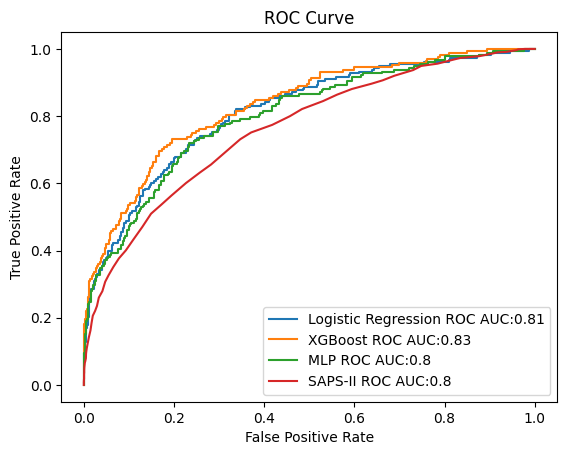

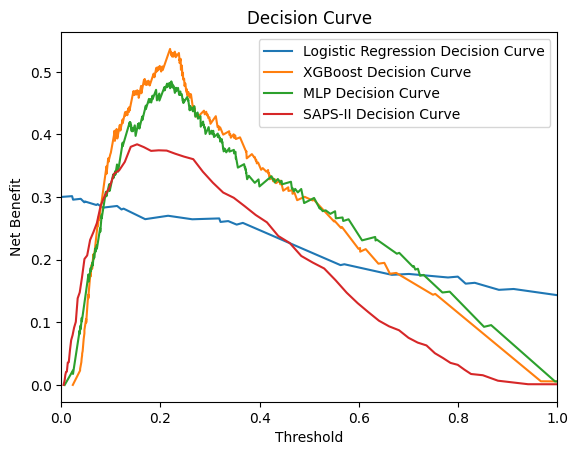

In [ ]:

model_type_list = ["Logistic Regression", "XGBoost", "MLP", "SAPS-II"]

# Results for features used in research paper
lr_results = calculate_stats(lr_model, lr_data_list)
xgb_results = calculate_stats(xgb_model, xgb_data_list)
mlp_results = calculate_stats_mlp(mlp_model, mlp_data_list[1])
sapsII_results = calculate_stats_sapsII(sapsII_pred, sapsII_label, sapsII_prob)
all_results = pd.DataFrame(pd.concat([lr_results, xgb_results, mlp_results, sapsII_results]).reset_index(drop = True))
#print(all_results)
#print(mlp_results)
result_figures(all_results, model_type_list)
# plot figures to better show the results

# it is better to save the numbers and figures for your presentation.

In [ ]:
all_results['Model'] = model_type_list
all_results = all_results.reindex(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
all_results

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.845395,0.728395,0.331461,0.455598,0.812548
1,XGBoost,0.858553,0.841270,0.308140,0.451064,0.831631
2,MLP,0.843202,0.716049,0.325843,0.447876,0.800393
3,SAPS-II,0.827813,0.680556,0.220472,0.333050,0.761021


### ROC-AUC and Decision Curve - Features from Boruta

<Figure size 1500x1000 with 0 Axes>

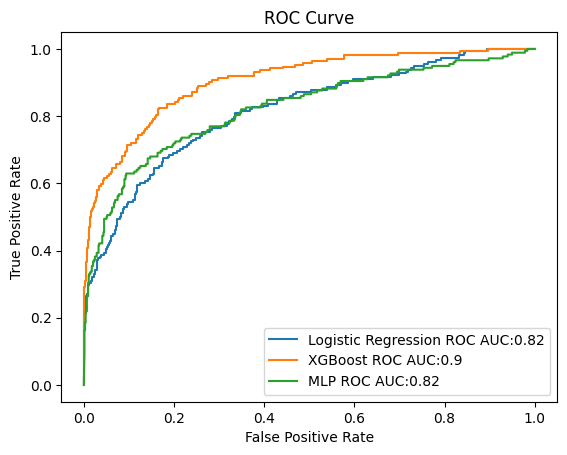

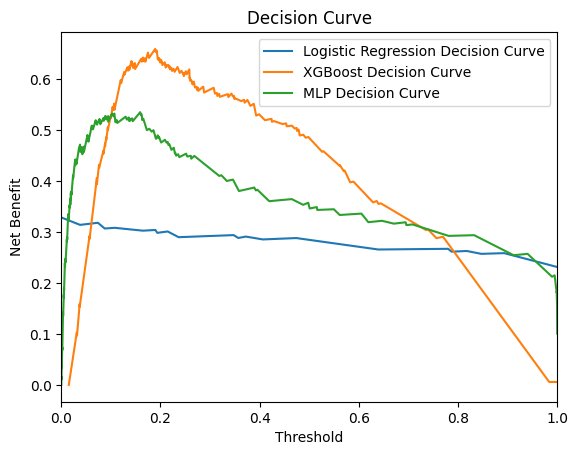

In [ ]:
roc_results = []
decision_curve_coords = []

model_type_list_boruta = ["Logistic Regression", "XGBoost", "MLP"]

# Results for features used in research paper
lr_results_boruta = calculate_stats(lr_model_boruta, lr_data_list_boruta)
xgb_results_boruta = calculate_stats(xgb_model_boruta, xgb_data_list_boruta)
mlp_results_boruta = calculate_stats_mlp(mlp_model_boruta, mlp_data_list_boruta[1])
all_results_boruta = pd.DataFrame(pd.concat([lr_results_boruta, xgb_results_boruta, mlp_results_boruta]).reset_index(drop = True))
#print(all_results)
#print(mlp_results)
result_figures(all_results_boruta, model_type_list, boruta=True)

In [ ]:
all_results_boruta['Model'] = model_type_list_boruta
all_results_boruta = all_results_boruta.reindex(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
all_results_boruta

,Model,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,0.851974,0.752941,0.359551,0.486692,0.815740
1,XGBoost,0.893640,0.894737,0.494186,0.636704,0.904871
2,MLP,0.857456,0.785714,0.370787,0.503817,0.822995


## Model Comparison

In [ ]:
# compare you model with others
# you don't need to re-run all other experiments, instead, you can directly refer the metrics/numbers in the paper

all_results['Feature Set'] = 'Original'
all_results = all_results.reindex(columns=['Model', 'Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])

all_results_boruta['Feature Set'] = 'Boruta'
all_results_boruta = all_results_boruta.reindex(columns=['Model', 'Feature Set', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC'])
all_results_boruta

all_results_final = pd.concat((all_results, all_results_boruta), axis=0)
all_results_final

,Model,Feature Set,Accuracy,Precision,Recall,F1,ROC
0,Logistic Regression,Original,0.845395,0.728395,0.331461,0.455598,0.812548
1,XGBoost,Original,0.858553,0.841270,0.308140,0.451064,0.831631
2,MLP,Original,0.843202,0.716049,0.325843,0.447876,0.800393
3,SAPS-II,Original,0.827813,0.680556,0.220472,0.333050,0.761021
0,Logistic Regression,Boruta,0.851974,0.752941,0.359551,0.486692,0.815740
1,XGBoost,Boruta,0.893640,0.894737,0.494186,0.636704,0.904871
2,MLP,Boruta,0.857456,0.785714,0.370787,0.503817,0.822995


Our results of the 3 models that are direct implementations of the models from the original paper generally agree with the performance seen in the initial research.  The ROC-AUC results from Logistic Regression are very similar (0.819 vs. 0.812) while our ROC-AUC results are slightly lower for the remaining two models, SAPS-II (0.797 vs. 0.761) and XGBoost (0.857 vs. 0.831).  

A principal reason for the inital research was to demonstrate whether it would be possible to utilize machine learning to help predict mortality in patients with sepsis and also whether machine learning could outperform heuristic methods (such as the SAPS-II system) that are currently in use.  Our results seem to confirm the original research goals and would support the hypothesis that machine learning could be leveraged to assist in identifying patients that are at higher risk of mortality.  There is a range of ROC-AUC performance among the models, but all of the machine learning models out-perform the SAPS-II system.  

Additionally, our experiments using a Multi-Layer Perceptron (MLP) and machine learning to select the feature set (via the Boruta algorithm) suggest that the initial results could be improved upon.  In both the original and Boruta selected feature sets, XGBoost outperformed the MLP when evaluating based on ROC-AUC.  The highest ROC-AUC performance for any of the 7 models was the XGBoost model using the larger Boruta selected feature set.  Each model using Boruta selected features performed better than the initial feature sets Logistic Regression(0.815 vs 0.812), MLP (0.823 vs 0.800), XGBoost(0.905 vs 0.832). This result suggests that there is still room to potentially improve the prediction accuracy of machine learning models in regards to predicting sepsis mortality.  

# Discussion

We believe that the original research paper is reproducible and provides an important demonstration that machine learning could be utilized to enhance clinical prediction of sepsis mortality. The results of our modeling experiment was similar to the results detailed in the original paper and we believe given the same feature set, results should be reproducible for future studies.  

The authors of the original study provided the cleaned data set with the paper and that eliminated a significant barrier to reproducing the research.  Also, the authors of the paper provided a significant amount of clinical background information as well as high-level details of the models during the modeling experiment.  Having access to the data and a good understanding of the problem was very helpful for replicating this experiment.  

Even though the modeling for this experiment was fairly straightforward, we did have challenges re-creating the original research.  While the authors did provide high-level details of the models, there was no mention of any type of hyperparameter tuning or other implementation details about the models themselves.  Since we did not have implementation details, we used default parameters for Logistic Regression and utilized grid search to tune the XGBoost model.  We assume tuning was conducted on XGBoost in the original study, but were unsure of the exact parameters since they were not specified.  

Additionally, the SAPS-II model was a challenge to figure out how to re-create that scoring system in our experiment.  We spent a significant amount of time researching the scoring system and recreated the scoring system and mortality calculation to have a way to verify that component of the research.  There are likely differences between our implementation of the SAPS-II system and the implementations used by hospitals.  This could be one reason why our implementation of SAPS-II results in a slightly lower ROC-AUC score in our experiments.  

To improve the reproducibility of this paper, we would recommend more details around the implementations of the machine learning models and the SAPS-II methodology that was used.  We recognize that there are not a lot of parameters to tune for Logisitic Regression, but information about which R package was used and ideally the code used to produce the analysis.  We utilized our own grid search for tuning the XGBoost model, but if the authors would have provided details on the final model parameters used in the analysis we believe that could have allowed for us to reproduce results that may be closer to the original research.  Additionally, while the researchers did provide the same data set that was used in the original research there was no mention of whether any variable transformations were used prior to modeling.  We did not employ any transformations in our data (since none were mentioned in the original paper) and we believe that is likely the approach the researchers employed.  



# Github Repo
https://github.com/jamyooes/dlh_project/tree/main



# References

1.   Hou, N., Li, M., He, L. et al. Predicting 30-days mortality for MIMIC-III patients with sepsis-3: a machine learning approach using XGboost., Journal of Translational Medicine, 2020, 18:462, doi: [https://doi.org/10.1186/s12967-020-02620-5](https://doi.org/10.1186/s12967-020-02620-5)

2. MD CALC *Simplified Acute Physiology Score (SAPS-II)*
https://www.mdcalc.com/calc/4044/simplified-acute-physiology-score-saps-ii

3. EBMcalc *SAPS II: Simplified Acute Physiology Score II*
https://ebmcalc.com/SAPS2.htm
